In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
from math import prod
from huggingface_hub import hf_hub_download
import tqdm
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])
import utils
from utils import get_all_bounding_boxes, segment, calculate_initial_theta, stack_alpha_aware, AestheticPredictor
from lion_pytorch import Lion
from datetime import datetime

In [3]:
im = Image.open('combined/5373.jpg')
im = im.convert('RGBA')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)


with open("combined/5373.json", "r") as f:
    image_json = json.load(f)

reduced_segments = [s for s in segment(im,image_json) if (prod(s[0].size) < 0.80*prod(im.size)) and (prod(s[0].size)>1)]
even_more_reduced_segments = [reduced_segments[i] for i in [2,4,5,6,7,8,10,11,12]]

In [4]:
class MultiSegmentUIOptimizerWithBackgroundParam(torch.nn.Module):
    def __init__(self,segments_and_positions: list, original_image_size: tuple):
        super().__init__()
        self.original_image_size = original_image_size
        self.segments_and_positions = segments_and_positions
        self.canvas_size = (1,3,original_image_size[1],original_image_size[0])
        print(f"Canvas size is {self.canvas_size}")

        initial_vector = []
        for segment,position in segments_and_positions:
            initial_theta = calculate_initial_theta(segment,original_image_size,position)
            initial_vector.append([initial_theta[0][2],initial_theta[1][2]])

        self.coordinates = torch.nn.Parameter(torch.tensor(initial_vector))
        print(self.coordinates)
        self.background_color = torch.nn.Parameter(torch.tensor(np.array([1.0,1.0,1.0]),dtype=torch.float))
        

    def forward(self):
        segments_on_canvas = []

        # Create background image from parameter
        bg_col = torch.clamp(self.background_color, min=0, max=1)
        #print(f"Clamped bg to {bg_col}")
        red = torch.tile(bg_col[0],self.original_image_size[::-1])
        green = torch.tile(bg_col[1],self.original_image_size[::-1])
        blue = torch.tile(bg_col[2],self.original_image_size[::-1])
        alpha = torch.tile(torch.tensor(0.0),self.original_image_size[::-1])
        background = torch.stack([red,green,blue,alpha]).unsqueeze(0)
        #print(background.detach().sum())
        #background = torch.tile(self.background_color,self.original_image_size)
        
        
        for n in range(len(self.segments_and_positions)):
            # We need to calculate the proper ratios, to artificially warp the segment on to a bigger canvas without distorting it (see notebook 01)
            x_ratio = self.original_image_size[0] / self.segments_and_positions[n][0].size[0]
            y_ratio = self.original_image_size[1] / self.segments_and_positions[n][0].size[1]
            
            # Affine matrix
            theta = [
                [x_ratio, 0.0    , 0.0],
                [0.0    , y_ratio, 0.0]
            ]
            theta_tensor = torch.as_tensor(theta)[None]

            theta_tensor[0][0][2]+=self.coordinates[n][0]
            theta_tensor[0][1][2]+=self.coordinates[n][1]
            
            # Generate flow field
            grid = F.affine_grid(theta_tensor, self.canvas_size).type(torch.FloatTensor)
            x = F.grid_sample(transform_to_t(self.segments_and_positions[n][0]).unsqueeze(0), grid)
            segments_on_canvas.append(x)

        segments_on_canvas.append(background)

        return segments_on_canvas

In [5]:
msUIo_wbg = MultiSegmentUIOptimizerWithBackgroundParam(even_more_reduced_segments, im.size)

Canvas size is (1, 3, 2560, 1440)
Parameter containing:
tensor([[ -5.8048,  13.3037],
        [  1.6321,  21.3044],
        [  0.5895,  12.0661],
        [  0.5249,   5.3056],
        [  1.4158,  11.2097],
        [  1.8943,   9.2690],
        [ -1.8578, -10.5006],
        [  0.0000, -12.3693],
        [  0.0000,  29.4762]], dtype=torch.float64, requires_grad=True)


/Users/mowoe/Documents/bachelorthesis/venv/lib/python3.11/site-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/mowoe/Documents/bachelorthesis/venv/lib/python3.11/site-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


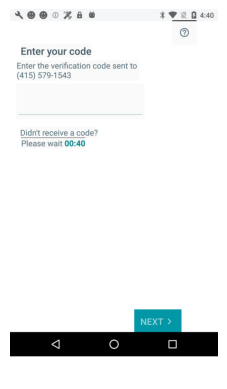

In [6]:
canvasses = msUIo_wbg()


generated_image = stack_alpha_aware(canvasses)
# Remove Alpha channel
generated_image = generated_image[:3]

plt.imshow(generated_image.detach().permute(1, 2, 0))
plt.axis('off')
plt.show()

In [7]:
appsthetics_predictor = torch.load("./resnet_50_20_epochs_2024-05-13T14:03")

In [9]:
appsthetics_predictor.eval()
1

1

In [10]:
optimizer = Lion(msUIo_wbg.parameters(), lr=15e-3, weight_decay=1e-2)

In [12]:
scores = []
images_for_gif = []

for x in tqdm.tqdm(range(20)):
    optimizer.zero_grad()
    canvasses = msUIo_wbg()
    
    generated_image = stack_alpha_aware(canvasses)
    # Remove Alpha channel
    generated_image = generated_image[:3]

    score = appsthetics_predictor(generated_image.unsqueeze(0))
    print(score)

    loss = -score
    loss.backward()
    optimizer.step()

    scores.append(score.item())

    # Save image as png to create gif
    pil_image = transform_t_to_pil(generated_image.detach())
    pil_image = pil_image.resize((int(pil_image.size[0]/4),int(pil_image.size[1]/4)), Image.Resampling.LANCZOS)
    pil_image.save(f"{x}.png")
    images_for_gif.append(f"{x}.png")
    #pbar.set_description(f"Score: {score}")
    #pbar.refresh()

print(f"Final Score: {score[-1]}")

  0%|                                                                                                                                                                                                            | 0/20 [00:00<?, ?it/s]

tensor([[0.2231]], grad_fn=<AddmmBackward0>)


  5%|█████████▊                                                                                                                                                                                          | 1/20 [00:09<02:58,  9.40s/it]

tensor([[0.2743]], grad_fn=<AddmmBackward0>)


 10%|███████████████████▌                                                                                                                                                                                | 2/20 [00:19<02:52,  9.57s/it]

tensor([[0.2718]], grad_fn=<AddmmBackward0>)


 15%|█████████████████████████████▍                                                                                                                                                                      | 3/20 [00:28<02:41,  9.47s/it]

tensor([[0.2795]], grad_fn=<AddmmBackward0>)


 20%|███████████████████████████████████████▏                                                                                                                                                            | 4/20 [00:37<02:26,  9.14s/it]

tensor([[0.2724]], grad_fn=<AddmmBackward0>)


 25%|█████████████████████████████████████████████████                                                                                                                                                   | 5/20 [00:45<02:15,  9.02s/it]

tensor([[0.2878]], grad_fn=<AddmmBackward0>)


 30%|██████████████████████████████████████████████████████████▊                                                                                                                                         | 6/20 [00:54<02:05,  8.96s/it]

tensor([[0.2767]], grad_fn=<AddmmBackward0>)


 35%|████████████████████████████████████████████████████████████████████▌                                                                                                                               | 7/20 [01:03<01:55,  8.88s/it]

tensor([[0.2943]], grad_fn=<AddmmBackward0>)


 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 8/20 [01:11<01:44,  8.74s/it]

tensor([[0.2718]], grad_fn=<AddmmBackward0>)


 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 9/20 [01:20<01:35,  8.64s/it]

tensor([[0.3045]], grad_fn=<AddmmBackward0>)


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 10/20 [01:29<01:27,  8.75s/it]

tensor([[0.2726]], grad_fn=<AddmmBackward0>)


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 11/20 [01:38<01:20,  8.94s/it]

tensor([[0.2879]], grad_fn=<AddmmBackward0>)


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 12/20 [01:48<01:12,  9.07s/it]

tensor([[0.3030]], grad_fn=<AddmmBackward0>)


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 13/20 [01:57<01:03,  9.11s/it]

tensor([[0.2869]], grad_fn=<AddmmBackward0>)


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 14/20 [02:06<00:54,  9.03s/it]

tensor([[0.2951]], grad_fn=<AddmmBackward0>)


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 15/20 [02:14<00:44,  8.92s/it]

tensor([[0.2835]], grad_fn=<AddmmBackward0>)


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 16/20 [02:23<00:35,  8.80s/it]

tensor([[0.2906]], grad_fn=<AddmmBackward0>)


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 17/20 [02:32<00:26,  8.89s/it]

tensor([[0.3016]], grad_fn=<AddmmBackward0>)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [02:41<00:17,  8.85s/it]

tensor([[0.2881]], grad_fn=<AddmmBackward0>)


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [02:50<00:08,  8.93s/it]

tensor([[0.2878]], grad_fn=<AddmmBackward0>)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:58<00:00,  8.94s/it]

Final Score: tensor([0.2878], grad_fn=<SelectBackward0>)


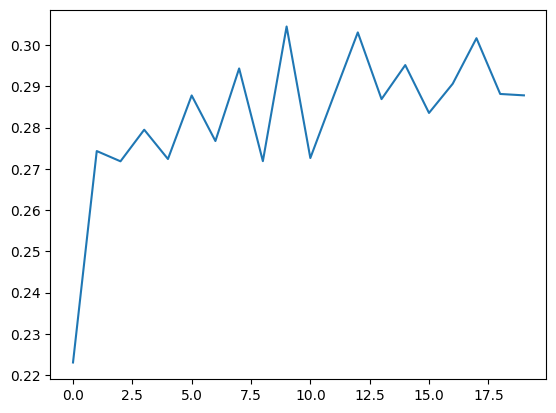

In [13]:
plt.plot(scores)
plt.show()

/var/folders/zp/wdq5n2513f916zsjngb1hs_c0000gn/T/ipykernel_50972/979258874.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
/var/folders/zp/wdq5n2513f916zsjngb1hs_c0000gn/T/ipykernel_50972/979258874.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



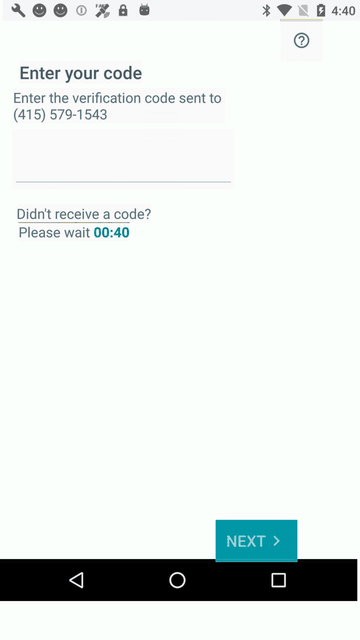

In [18]:
# Create gif from steps
import imageio

images = []
for filename in images_for_gif:
    images.append(imageio.imread(filename))

gif_filename = f"./progress_{datetime.now().isoformat(timespec='minutes')}.gif"
imageio.mimsave(gif_filename, images, loop=65535)

import base64
from IPython.core.display import display, HTML

b64 = base64.b64encode(open(gif_filename,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))